 # ML/DL based models for colorectal cancer subtype identification

 **Background:** Cancer molecular subtyping plays a critical role in individualized patient treatment and provides important biological insights into tumor heterogeneity. Gene expression signature-based methods are widely used to identify cancer subtypes. These methods suffer from the curse of dimensionality, data sparsity, and computational deficiency. New approaches addressing these limitations have been introduced - DeepType, DeepCC, DeepCSD atd. A new supervised learning framework based on deep learning will be introduced to identify cancer subtypes and address the limitations of other methods.

 **Methods:** a range of ML/DL methods will be used in order to increase the precision of subtype identification. Imbalanced classification techniques might be used in order to improve classification accuracy.I will use R for preprocessing of data and Python for the analysis of subtypes.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

**Data source:**  https://www.synapse.org/#!Synapse:syn2634742 

**Existing frameworks (DeepType, DeepCC, DeepCSD):**
* https://www.nature.com/articles/s41389-019-0157-8 
* https://academic.oup.com/bioinformatics/article/36/5/1476/5585742
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8215925/

**My comparison of frameworks:**
https://docs.google.com/presentation/d/1p9Rfom5t-wv09leiFySewhunjPq-k9O3ym78R6a5rBo/edit#slide=id.g1546a73b51c_0_4

**NOTES:**
* So far nul values were filled with zero suggesting that we have no info about the expression of some genes
* Later I also would like to try to interpolate it and filled it based on the technology that used to generate these data

## Data Loading and Preparation

In [19]:
# functions used in this script
def get_ensembl_mappings():
  '''
  this function is used to call table for  HUGO gene ID to ENTREZ ID conversion
  '''
  # Set up connection to server 
  import biomart
  from io import StringIO                                             
  server = biomart.BiomartServer('http://ensembl.org/biomart')         
  mart = server.datasets['hsapiens_gene_ensembl']                            
  # List the types of data we want                                            
  response = mart.search({'attributes':  ["affy_hg_u133_plus_2", "hgnc_symbol", "entrezgene_id"]})                          
  data = response.raw.data.decode('ascii')                                    
  
  df = pd.read_csv(StringIO(data), sep="\t", names=["Affymetrix", "Hugo", "Entrez"], header=0)
  df = df.dropna()
  df.Entrez = df.Entrez.astype("int")
  df = df.astype(object)                                                                                  
  return df

def merge_counts(counts_df, mapping_df, column, index_column, drop_col):
  counts_df = pd.merge(counts_df, df, left_index=True, right_on = f"{column}", how="left")
  counts_df = counts_df.drop_duplicates(f"{index_column}")
  counts_df = counts_df.dropna()
  counts_df = counts_df.drop([f"{column}", f"{drop_col}"], axis=1)
  counts_df = counts_df.set_index(f"{index_column}")
  counts_df.index.name = f"{index_column}"
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df = counts_df[counts_df.index != ""]
  counts_df.sort_index(inplace=True)
  return counts_df
 
def prepare_labels(df, GEO_ID):
  df = df[df["dataset"] == GEO_ID]
  df = df[["sample","CMS_network"]]
  df.reset_index()
  return df

def scale_pca(df):
  sc = StandardScaler()
 
  X_scaled_df = sc.fit_transform(df.T)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.T.columns)

  pca = PCA()
  components = pca.fit_transform(X_scaled_df.T)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)


In [ ]:
# importing necessary packages
!pip install biomart
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as ss

# Model fine-tuning and evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

path = "/content/drive/MyDrive/MY_DATA/Colorectal_cancer/"
#path = "../../"


In [20]:
df = get_ensembl_mappings()
df.head()

Affymetrix    Hugo Entrez
4   1553551_s_at  MT-ND1   4535
8   1553551_s_at  MT-ND2   4536
14  1553538_s_at  MT-CO1   4512
15  1553570_x_at  MT-CO1   4512
16    1553569_at  MT-CO1   4512

In [14]:
annt_df = pd.read_csv(f"/content/drive/MyDrive/MY_DATA/annotation.csv.zip", compression="zip")
annt_df = annt_df[annt_df["Cancer type"] == "Colorectal"]
d_ilmn = dict(annt_df[["ID", "Technology"]].values)
len(d_ilmn)

14

### GSE files

This script is used mainly to ckeck demensions and labels of the data.

In [15]:
# loading data 
from pandas.io.parsers.readers import read_csv

label_geo_df = pd.DataFrame()
gse_count_df = pd.DataFrame() 
labels_df = pd.read_csv(f"{path}/labels_df.csv.zip", sep=";")

count = 0
for f in os.listdir(path):
  if f.startswith("GSE"):
    count += 1
    counts_df = pd.read_csv(f"{path}/{f}", index_col=0, sep="\t")
    label_gse_df = prepare_labels(labels_df, f.split("_", 1)[0].lower())
    counts_df.sort_index(inplace=True)
    new_names = counts_df.columns.tolist()
    if f.split("_", 1)[0] in ["GSE33113", "GSE23878", "GSE14333", "GSE2109", "GSE17536", "GSE13067", "GSE13294"]:
      new_names = [i.split(".")[0] for i in counts_df.columns.tolist()]
    if f.split("_", 1)[0] in ["GSE35896", "GSE20916", "GSE37892", "GSE39582"]:
      new_names = [i.split("_", 1)[0] for i in counts_df.columns.tolist()]
    counts_df.columns = new_names
    # new lines
    label_gse_df = label_gse_df[label_gse_df["sample"].isin(counts_df.columns)]
    counts_df = counts_df[label_gse_df["sample"].tolist()]
    label_geo_df = label_geo_df.append(label_gse_df)
    gse_count_df = gse_count_df.append(counts_df.T)
    print(count, f.split("_", 1)[0], "Shape - ", counts_df.shape, "Null - ", sum(counts_df.isna().sum()), "Labels - ", len(label_gse_df))

1 GSE23878 Shape -  (54675, 24) Null -  0 Labels -  24
2 GSE17536 Shape -  (54675, 147) Null -  0 Labels -  147
3 GSE13294 Shape -  (54675, 124) Null -  0 Labels -  124
4 GSE39582 Shape -  (54675, 466) Null -  0 Labels -  466
5 GSE35896 Shape -  (54675, 51) Null -  0 Labels -  51
6 GSE2109 Shape -  (54675, 244) Null -  0 Labels -  244
7 GSE14333 Shape -  (54675, 129) Null -  0 Labels -  129
8 GSE13067 Shape -  (54675, 57) Null -  0 Labels -  57
9 GSE37892 Shape -  (54675, 107) Null -  0 Labels -  107
10 GSE33113 Shape -  (54675, 80) Null -  0 Labels -  80
11 GSE20916 Shape -  (54675, 45) Null -  0 Labels -  45


From above we can see that for some datasets we have less labels that actual columns in count matrix (GSE14333, GSE20916, GSE23878, GSE33113).

In [16]:
gse_count_df.shape

(1474, 54675)

In [18]:
gse_count_df.head()

1007_s_at   1053_at    117_at    121_at  1255_g_at   1294_at  \
GSM588828   9.730369  6.754458  5.789453  7.487078   3.444420  8.021613   
GSM588829   9.943416  5.911208  5.564561  7.722490   3.685059  7.459083   
GSM588830  10.190126  6.036607  5.844348  7.973559   3.618895  7.356346   
GSM588831  10.017243  6.743441  5.594474  7.892333   3.639162  7.288538   
GSM588832   9.990561  6.337200  6.392972  7.603757   3.722730  7.153211   

            1316_at   1320_at  1405_i_at   1431_at  ...  \
GSM588828  5.462968  4.774885   8.771696  3.501426  ...   
GSM588829  5.508320  4.350154   6.470138  3.894922  ...   
GSM588830  5.429070  4.242512   7.264567  3.592176  ...   
GSM588831  5.323726  4.569409   4.393263  3.646026  ...   
GSM588832  5.158622  4.445327   4.413914  3.456774  ...   

           AFFX-r2-Bs-thr-M_s_at  AFFX-r2-Ec-bioB-3_at  AFFX-r2-Ec-bioB-5_at  \
GSM588828               7.278100              9.039876              9.118882   
GSM588829               5.478019              9.519990              9.848590   
GSM588830               7.855664              9.021418              8.844112   
GSM588831               6.858579              8.343616              8.275699   
GSM588832               7.059783              8.314242              7.975636   

           AFFX-r2-Ec-bioB-M_at  AFFX-r2-Ec-bioC-3_at  AFFX-r2-Ec-bioC-5_at  \
GSM588828              8.976331             10.454629             10.152199   
GSM588829              9.740867             11.022285             11.171912   
GSM588830              8.588626             10.282624             10.039945   
GSM588831              8.392101              9.736086              9.429585   
GSM588832              8.003210              9.473306              9.220428   

           AFFX-r2-Ec-bioD-3_at  AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  \
GSM588828             12.252265             12.168202            13.510581   
GSM588829             12.849970             12.739038            13.697219   
GSM588830             12.362685             12.180703            13.662670   
GSM588831             11.869565             11.709973            13.243984   
GSM588832             11.676192             11.491494            13.164457   

           AFFX-r2-P1-cre-5_at  
GSM588828            13.571465  
GSM588829            13.797362  
GSM588830            13.443291  
GSM588831            13.041716  
GSM588832            12.963993  

[5 rows x 54675 columns]

In [21]:
gse_count_df = merge_counts(gse_count_df.T, df, "Affymetrix", "Entrez", "Hugo")
gse_count_df.shape

(20315, 1474)

In [22]:
label_geo_df.groupby("CMS_network")["sample"].count().sum()

1474

In [23]:
round(label_geo_df["CMS_network"].value_counts(normalize=True)*100,2)

CMS2    42.81
CMS4    25.03
CMS1    19.06
CMS3    13.09
Name: CMS_network, dtype: float64

In [24]:
%%script false --no-raise-error
gse_count_df.to_csv(f"{path}/all_preprocessed/X_GEO.csv.tar.gz", compression = "gzip")
label_geo_df.to_csv("y_GEO.csv.tar.gz", compression = "gzip")

In [ ]:
train_features, test_features, train_targets, test_targets = train_test_split(
        gse_count_df.T, label_geo_df["CMS_network"],
        train_size=0.80,
        test_size=0.20,
        random_state=23,
        stratify=label_geo_df["CMS_network"])

In [ ]:
round(test_targets.value_counts(normalize=True)*100,2)

CMS2    42.71
CMS4    25.08
CMS1    18.98
CMS3    13.22
Name: CMS_network, dtype: float64

In [ ]:
round(train_targets.value_counts(normalize=True)*100,2)

CMS2    42.83
CMS4    25.02
CMS1    19.08
CMS3    13.06
Name: CMS_network, dtype: float64

In [ ]:
%%script false --no-raise-error
train_features.to_csv(f"{path}/training_data/X_GEO_CRC.csv.tar.gz", compression = "gzip")
train_targets.to_csv(f"{path}/training_data/y_GEO_CRC.csv.tar.gz", compression = "gzip")
test_features.to_csv(f"{path}/testing_data/X_GEO_CRC.csv.tar.gz", compression = "gzip")
test_targets.to_csv(f"{path}/testing_data/y_GEO_CRC.csv.tar.gz", compression = "gzip")

### TCGA

In [25]:
counts_tcga_df = pd.read_csv(f"{path}/TCGACRC_expression.zip",index_col=0, sep="\t")
counts_tcga_df.tail()

TCGA-AA-A01I  TCGA-AA-3684  TCGA-AA-A004  TCGA-AA-3680  TCGA-A6-2670  \
feature                                                                         
ZYG11A       0.000000      2.242237      0.000000      1.742437      0.000000   
ZYG11B       9.061741      7.301189      4.700440      9.118493      9.035650   
ZYX         10.583447     13.747249     13.295051     12.043921     12.391548   
ZZEF1       10.240996     11.021923     10.667112     10.559830      9.938991   
ZZZ3        10.052761      7.579682      7.238405      9.759341      9.006263   

         TCGA-AA-3870  TCGA-AA-3560  TCGA-AA-3811  TCGA-AA-A00O  TCGA-AA-3862  \
feature                                                                         
ZYG11A       0.000000      2.122905      2.429214      1.491391      0.000000   
ZYG11B       8.968667      8.320990      8.839950      9.490444      8.696417   
ZYX         13.242276     11.043069     11.980309     11.096920     12.325406   
ZZEF1       10.409555      9.838305     10.555918      9.743115      9.166028   
ZZZ3         9.085482      9.452580      9.185223      9.879772      9.051647   

         ...  TCGA-AG-A036  TCGA-AG-3584  TCGA-AG-3608  TCGA-AG-3893  \
feature  ...                                                           
ZYG11A   ...      3.276095      2.360786      0.000000      3.039823   
ZYG11B   ...      9.179397      8.130386      8.648567      9.202700   
ZYX      ...     11.707124     13.160846     12.365519     12.365095   
ZZEF1    ...     10.096082     10.405928      9.504936     10.377433   
ZZZ3     ...      9.906688      8.396994      8.986951      9.127498   

         TCGA-AG-3898  TCGA-AG-A016  TCGA-AG-3887  TCGA-AG-3581  TCGA-AG-A00C  \
feature                                                                         
ZYG11A       0.000000      1.090447      1.822975      0.000000      1.985683   
ZYG11B       8.749827      8.334892      8.628154      8.601033      8.990742   
ZYX         12.921598     13.011232     12.098531     12.494018     12.018943   
ZZEF1        9.399511     10.933727      9.983594     10.245474     10.114036   
ZZZ3         9.115944      9.057892      9.285625      9.381546      9.056391   

         TCGA-AG-3594  
feature                
ZYG11A       0.000000  
ZYG11B       8.777090  
ZYX         12.189473  
ZZEF1        9.816917  
ZZZ3         9.912480  

[5 rows x 263 columns]

In [26]:
counts_tcga_df = merge_counts(counts_tcga_df, df, "Hugo", "Entrez", "Affymetrix")
counts_tcga_df.head()

TCGA-AA-A01I  TCGA-AA-3684  TCGA-AA-A004  TCGA-AA-3680  TCGA-A6-2670  \
Entrez                                                                         
1           2.894527      7.176489      7.477758      5.097725      4.683214   
2          11.258449     13.757572     11.514714     12.722776     12.290497   
9           8.150691      7.231257      5.672425      8.004014      7.963920   
10          7.939988      6.090942      0.000000      8.068473      8.298901   
12          7.742936      8.603848     10.199672      6.456177      4.953377   

        TCGA-AA-3870  TCGA-AA-3560  TCGA-AA-3811  TCGA-AA-A00O  TCGA-AA-3862  \
Entrez                                                                         
1           5.546567      1.421102      5.500337      4.852473      4.471604   
2          12.730804     13.111064     12.548544     13.874176     11.354735   
9           6.513737      7.413316      7.026645      6.789226      7.675179   
10          4.023096      5.424462      5.556203      5.146505      6.600585   
12          6.357304     10.425385      6.818162      4.323493      7.340000   

        ...  TCGA-AG-A036  TCGA-AG-3584  TCGA-AG-3608  TCGA-AG-3893  \
Entrez  ...                                                           
1       ...      4.222488      5.225414      5.790561      4.788999   
2       ...     12.188519     12.549204     11.626870     12.790620   
9       ...      6.475074      7.276913      7.586068      7.568750   
10      ...      4.573150      5.295087      7.578534      6.915413   
12      ...      6.365339      4.747022      6.943617      5.470657   

        TCGA-AG-3898  TCGA-AG-A016  TCGA-AG-3887  TCGA-AG-3581  TCGA-AG-A00C  \
Entrez                                                                         
1           5.079826      2.879451      5.087246      4.880627      3.844647   
2          12.183902     11.213609     11.878715     12.398589     10.453220   
9           7.807850      6.440236      8.117122      7.820521      7.550833   
10          7.274692      6.239219      8.557021      7.418684      7.562178   
12          5.519536      4.560024      8.168933      8.250586      3.982081   

        TCGA-AG-3594  
Entrez                
1           5.025742  
2          11.885535  
9           7.690262  
10          6.565547  
12          6.804210  

[5 rows x 263 columns]

In [27]:
counts_tcga_df.shape

(16070, 263)

In [28]:
sum(counts_tcga_df.isna().sum())

0

In [29]:
label_tcga_df = prepare_labels(labels_df, "tcga") 
len(label_tcga_df)

459

In [30]:
label_tcga_df = label_tcga_df[label_tcga_df["sample"].isin(counts_tcga_df.columns)]
label_tcga_df.shape

(207, 2)

In [31]:
counts_tcga_df = counts_tcga_df[label_tcga_df["sample"].tolist()]
counts_tcga_df.shape

(16070, 207)

In [32]:
%%script false --no-raise-error
counts_tcga_df.to_csv(f"{path}/all_preprocessed/X_TCGA.csv.tar.gz", compression = "gzip")
label_tcga_df.to_csv("y_tcga.csv.tar.gz", compression = "gzip")

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
        counts_tcga_df.T, label_tcga_df["CMS_network"],
        train_size=0.80,
        test_size=0.20,
        random_state=23,
        stratify=label_tcga_df["CMS_network"])

In [34]:
round(y_test.value_counts(normalize=True)*100,2)

CMS2    47.62
CMS4    21.43
CMS1    16.67
CMS3    14.29
Name: CMS_network, dtype: float64

In [35]:
round(y_train.value_counts(normalize=True)*100,2)

CMS2    49.09
CMS4    20.61
CMS1    16.97
CMS3    13.33
Name: CMS_network, dtype: float64

In [36]:
%%script false --no-raise-error
x_train.to_csv(f"{path}/training_data/X_TCGA_CRC.csv.tar.gz", compression = "gzip")
y_train.to_csv(f"{path}/training_data/y_TCGA_CRC.csv.tar.gz", compression = "gzip")
x_test.to_csv(f"{path}/testing_data/X_TCGA_CRC.csv.tar.gz", compression = "gzip")
y_test.to_csv(f"{path}/testing_data/y_TCGA_CRC.csv.tar.gz", compression = "gzip")

### PETACC3

In [37]:
# this df is used to process PETACC3 dataset
helper_df = pd.read_csv(f"{path}/A-AFFY-101.adf.txt.zip", sep="\t", skiprows=12)
helper_df = helper_df[["Composite Element Name",'Composite Element Database Entry[locus]']]
helper_df.columns = ["Hybridization REF", "entrezgene_id"]
helper_df.shape

(61528, 2)

In [38]:
counts_petacc3_df = pd.read_csv(f"{path}/PETACC3_expression.zip", sep="\t")
counts_petacc3_df.index.name = ""
counts_petacc3_df.head()

Hybridization REF  PETACC3-0244  PETACC3-0268  PETACC3-0180  PETACC3-0596  \
                                                                              
0    AFFX-BioB-5_at      11.38667      11.38643      11.08049      11.57510   
1    AFFX-BioB-M_at      11.99590      12.19502      11.97303      12.22600   
2    AFFX-BioB-3_at      12.15398      12.31590      12.18325      12.31942   
3    AFFX-BioC-5_at      12.61940      12.78452      12.64269      12.81759   
4    AFFX-BioC-3_at      12.44868      12.63752      12.38745      12.63761   

   PETACC3-0411  PETACC3-0284  PETACC3-0546  PETACC3-0501  PETACC3-0641  ...  \
                                                                         ...   
0      11.52646      10.47507      10.80688      10.49251      10.94935  ...   
1      12.24482      11.40561      11.72135      11.33827      11.66504  ...   
2      12.42399      11.62715      11.84672      11.56346      11.86210  ...   
3      12.87965      11.96849      12.26492      12.03619      12.36589  ...   
4      12.63451      11.73705      11.90883      11.70874      12.11987  ...   

   PETACC3-0460  PETACC3-0044  PETACC3-0045  PETACC3-0046  PETACC3-0430  \
                                                                          
0      10.99508       8.48762       9.24470       9.14039       9.54746   
1      11.84584       9.62379      10.28222      10.07574      10.47987   
2      11.99931       9.89974      10.47548      10.38875      10.75418   
3      12.38901      10.68859      11.15133      11.01555      11.25224   
4      12.08058      10.11868      10.79183      10.52076      10.80610   

   PETACC3-0432  PETACC3-0431  PETACC3-0429  PETACC3-0426  PETACC3-0425  
                                                                         
0       9.91186       9.42792       8.62841       9.13921       8.10552  
1      10.76339      10.45566       9.51636      10.21202       9.06640  
2      10.88921      10.68703       9.86565      10.69220       9.37538  
3      11.59389      11.24138      10.89544      11.51985      10.26557  
4      11.28438      10.87807      10.43286      11.19916       9.80726  

[5 rows x 689 columns]

In [39]:
counts_petacc3_df.shape

(61528, 689)

In [40]:
helper_df = helper_df.dropna()
helper_df.shape

(49998, 2)

In [41]:
counts_petacc3_df = helper_df.merge(counts_petacc3_df, how="left", on="Hybridization REF")
counts_petacc3_df.shape

(49998, 690)

In [42]:
counts_petacc3_df = counts_petacc3_df[counts_petacc3_df['entrezgene_id'].notna()]
counts_petacc3_df = counts_petacc3_df.drop_duplicates(subset = "entrezgene_id")
counts_petacc3_df.shape

(15842, 690)

In [43]:
counts_petacc3_df = counts_petacc3_df.set_index("entrezgene_id")
counts_petacc3_df = counts_petacc3_df.drop("Hybridization REF", axis=1)
counts_petacc3_df.sort_index(inplace=True)

In [44]:
sum(counts_petacc3_df.isna().sum())

0

In [45]:
label_petacc3_df = prepare_labels(labels_df, "petacc3") 
len(label_petacc3_df)

526

In [46]:
label_petacc3_df = label_petacc3_df[label_petacc3_df["sample"].isin(counts_petacc3_df.columns)]
label_petacc3_df.shape

(526, 2)

In [47]:
counts_petacc3_df = counts_petacc3_df[label_petacc3_df["sample"].tolist()]
counts_petacc3_df.sort_index(inplace=True)
counts_petacc3_df.shape

(15842, 526)

In [48]:
counts_petacc3_df.to_csv(f"{path}/all_preprocessed/X_petacc3.csv.tar.gz", compression = "gzip")
label_petacc3_df.to_csv("y_petacc3.csv.tar.gz", compression = "gzip")

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
        counts_petacc3_df.T, label_petacc3_df["CMS_network"],
        train_size=0.80,
        test_size=0.20,
        random_state=23,
        stratify=label_petacc3_df["CMS_network"])

In [50]:
round(y_test.value_counts(normalize=True)*100,2)

CMS2    45.28
CMS4    26.42
CMS1    15.09
CMS3    13.21
Name: CMS_network, dtype: float64

In [51]:
round(y_train.value_counts(normalize=True)*100,2)

CMS2    45.00
CMS4    26.90
CMS1    14.52
CMS3    13.57
Name: CMS_network, dtype: float64

In [52]:
%%script false --no-raise-error
X_train.to_csv(f"{path}/training_data/X_PETACC3_CRC.csv.tar.gz", compression = "gzip")
y_train.to_csv(f"{path}/training_data/y_PETACC3_CRC.csv.tar.gz", compression = "gzip")
X_test.to_csv(f"{path}/testing_data/X_PETACC3_CRC.csv.tar.gz", compression = "gzip")
y_test.to_csv(f"{path}/testing_data/y_PETACC3_CRC.csv.tar.gz", compression = "gzip")

### KFSYSCC

In [53]:
counts_kfsyscc_df = pd.read_csv(f"{path}/KFSYSCC_frma_expression.zip",index_col=0, sep="\t")
counts_kfsyscc_df.tail()

COLON001.CEL  COLON002.CEL  COLON003.CEL  COLON004.CEL  \
AFFX-ThrX-5_at       7.558619      7.178968      7.156833      7.357738   
AFFX-ThrX-M_at       7.793918      7.340630      7.494361      7.702025   
AFFX-TrpnX-3_at      2.935507      2.952419      3.011267      3.013891   
AFFX-TrpnX-5_at      3.438793      3.477349      3.400292      3.431387   
AFFX-TrpnX-M_at      3.333143      3.361064      3.252660      3.237155   

                 COLON005.CEL  COLON006.CEL  COLON007.CEL  COLON008.CEL  \
AFFX-ThrX-5_at       7.022129      7.150997      7.122412      6.743170   
AFFX-ThrX-M_at       6.962394      7.421895      7.288007      6.851420   
AFFX-TrpnX-3_at      2.939097      2.933068      3.051066      3.036861   
AFFX-TrpnX-5_at      3.426369      3.478599      3.224925      3.566977   
AFFX-TrpnX-M_at      3.377685      3.443339      3.578731      3.289461   

                 COLON009.CEL  COLON010.CEL  ...  COLON313.CEL  COLON314.CEL  \
AFFX-ThrX-5_at       6.705053      5.947729  ...      3.920977      3.860761   
AFFX-ThrX-M_at       6.862310      6.533331  ...      3.620869      3.739304   
AFFX-TrpnX-3_at      3.075843      2.907919  ...      2.933542      3.067728   
AFFX-TrpnX-5_at      3.380028      3.416253  ...      3.420893      3.401328   
AFFX-TrpnX-M_at      3.546598      3.315596  ...      3.132170      3.141046   

                 COLON315.CEL  COLON316.CEL  COLON317.CEL  COLON318.CEL  \
AFFX-ThrX-5_at       3.788049      3.858415      3.841573      3.837027   
AFFX-ThrX-M_at       3.510777      3.677875      3.738445      3.578325   
AFFX-TrpnX-3_at      3.010462      2.939699      2.946448      2.936388   
AFFX-TrpnX-5_at      3.457940      3.400251      3.329452      3.388530   
AFFX-TrpnX-M_at      3.261173      3.196077      3.164372      3.127216   

                 COLON319.CEL  COLON320.CEL  COLON321.CEL  COLON322.CEL  
AFFX-ThrX-5_at       3.822057      3.885153      3.759881      3.837064  
AFFX-ThrX-M_at       3.535462      3.615400      3.280481      3.320071  
AFFX-TrpnX-3_at      2.854226      2.992363      2.904654      2.989783  
AFFX-TrpnX-5_at      3.267368      3.348000      3.292682      3.460105  
AFFX-TrpnX-M_at      3.101915      3.272628      3.126534      3.246091  

[5 rows x 322 columns]

In [54]:
counts_kfsyscc_df = merge_counts(counts_kfsyscc_df, df, "Affymetrix", "Entrez", "Hugo")
counts_kfsyscc_df.shape

(20315, 322)

In [55]:
counts_kfsyscc_df.isna().sum().sum()

0

In [56]:
new_names = [i.split(".")[0] for i in counts_kfsyscc_df.columns.tolist()]
new_names[1:5]

['COLON002', 'COLON003', 'COLON004', 'COLON005']

In [57]:
counts_kfsyscc_df.columns = new_names

In [58]:
label_kfsyscc_df = prepare_labels(labels_df, "kfsyscc")
len(label_kfsyscc_df)

229

In [59]:
label_kfsyscc_df = label_kfsyscc_df[label_kfsyscc_df["sample"].isin(counts_kfsyscc_df.columns)]
label_kfsyscc_df.shape

(229, 2)

In [60]:
counts_kfsyscc_df = counts_kfsyscc_df[label_kfsyscc_df["sample"].tolist()]
counts_kfsyscc_df.shape

(20315, 229)

In [61]:
%%script false --no-raise-error
counts_kfsyscc_df.to_csv(f"{path}/all_preprocessed/X_kfsyscc.csv.tar.gz", compression = "gzip")
label_kfsyscc_df.to_csv("y_kfsyscc.csv.tar.gz", compression = "gzip")

In [62]:
X_tra, X_te, y_tra, y_te = train_test_split(
        counts_kfsyscc_df.T, label_kfsyscc_df["CMS_network"],
        train_size=0.80,
        test_size=0.20,
        random_state=23,
        stratify=label_kfsyscc_df["CMS_network"])

In [63]:
round(y_te.value_counts(normalize=True)*100,2)

CMS2    39.13
CMS4    34.78
CMS3    15.22
CMS1    10.87
Name: CMS_network, dtype: float64

In [64]:
round(y_tra.value_counts(normalize=True)*100,2)

CMS2    39.89
CMS4    34.43
CMS3    13.66
CMS1    12.02
Name: CMS_network, dtype: float64

In [65]:
%%script false --no-raise-error
X_tra.to_csv(f"{path}/training_data/X_kfsyscc_CRC.csv.tar.gz", compression = "gzip")
y_tra.to_csv(f"{path}/training_data/y_kfsyscc_CRC.csv.tar.gz", compression = "gzip")
X_te.to_csv(f"{path}/testing_data/X_kfsyscc_CRC.csv.tar.gz", compression = "gzip")
y_te.to_csv(f"{path}/testing_data/y_kfsyscc_CRC.csv.tar.gz", compression = "gzip")

## All metadata labels

In [66]:
final_labels_df = pd.concat([label_geo_df, label_tcga_df, label_petacc3_df, label_kfsyscc_df])
final_labels_df.shape

(2436, 2)

In [67]:
final_labels_df.groupby("CMS_network")["sample"].count()

CMS_network
CMS1     420
CMS2    1060
CMS3     324
CMS4     632
Name: sample, dtype: int64

In [68]:
final_labels_df = final_labels_df[final_labels_df["CMS_network"]!="UNK"]
final_labels_df.shape

(2436, 2)

In [ ]:
final_labels_df.groupby("CMS_network")["sample"].count()

## Merged count matrices

In [69]:
print("GSE", gse_count_df.axes[0].tolist()[:5])
print("TCGA", counts_tcga_df.axes[0].tolist()[:5])
print("PATACC3", counts_petacc3_df.axes[0].tolist()[:5])
print("KFSYSCC", counts_kfsyscc_df.axes[0].tolist()[:5])

GSE [1, 2, 9, 10, 12]
TCGA [1, 2, 9, 10, 12]
PATACC3 [2.0, 9.0, 10.0, 12.0, 13.0]
KFSYSCC [1, 2, 9, 10, 12]


In [70]:
print("GSE", gse_count_df.shape)
print("TCGA", counts_tcga_df.shape)
print("PATACC3", counts_petacc3_df.shape)
print("KFSYSCC", counts_kfsyscc_df.shape)

GSE (20315, 1474)
TCGA (16070, 207)
PATACC3 (15842, 526)
KFSYSCC (20315, 229)


In [71]:
merged_df = gse_count_df.merge(counts_tcga_df, how="left",left_index=True, right_index=True).merge(counts_petacc3_df, how="left",left_index=True, right_index=True).merge(counts_kfsyscc_df, how="left",left_index=True, right_index=True)
merged_df.shape 

(20315, 2436)

In [72]:
merged_df.head()

GSM588828  GSM588829  GSM588830  GSM588831  GSM588832  GSM588833  \
Entrez                                                                     
1        5.084064   5.298532   5.139071   5.059688   5.091166   5.432077   
2       10.760943   9.889683  11.218220   9.393191   8.833060  11.088029   
9        9.389697   7.931403   8.760158   8.189032   8.246517   8.622447   
10       7.873178   6.573138   8.065168   6.158629   6.034616   8.375637   
12       6.697241   5.044780   6.550547   6.945066   4.889779   4.754532   

        GSM588835  GSM588837  GSM588838  GSM588839  ...  COLON309   COLON311  \
Entrez                                              ...                        
1        5.273619   5.278681   4.900385   5.038942  ...  4.989832   4.907673   
2       11.335618  11.407285  10.927366  10.688567  ...  9.391704  10.184089   
9        8.464803   8.943903   8.158279   8.149179  ...  7.226549   8.344495   
10       7.347183   8.245178   7.174777   5.807587  ...  5.685227   7.517797   
12       5.671982   5.130991   6.846118   7.008422  ...  5.562609   4.903011   

         COLON313  COLON314  COLON315   COLON316   COLON317  COLON318  \
Entrez                                                                  
1        5.183565  4.790792  4.820070   4.754985   4.898522  4.784457   
2       10.980469  9.568281  9.378937  10.491481  10.031182  9.943199   
9        8.239053  8.932637  6.560102   8.178757   7.328830  7.837315   
10       6.469289  5.582934  5.631502   7.067459   6.528703  6.707653   
12       7.207645  7.689768  4.846879   5.535309   5.431958  5.581735   

         COLON319   COLON320  
Entrez                        
1        5.410652   4.942731  
2       12.086362  10.119649  
9        7.079545   6.590414  
10       5.431990   6.102285  
12       7.555045   5.433386  

[5 rows x 2436 columns]

In [73]:
merged_df = merged_df[final_labels_df["sample"].tolist()]

In [74]:
merged_df.shape

(20315, 2436)

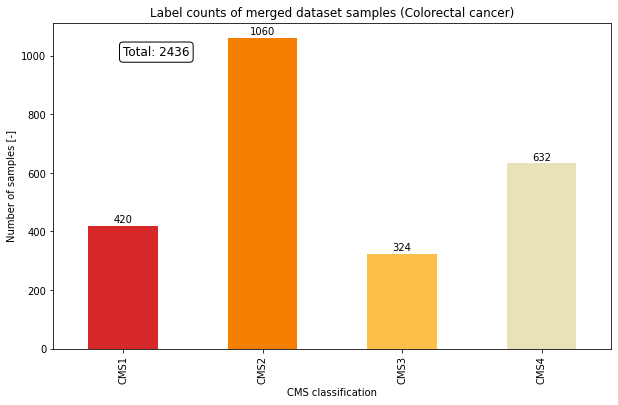

In [75]:
colors = ["#d62828", "#f77f00", "#fcbf49", "#eae2b7"]

frequencies = final_labels_df.groupby('CMS_network')["sample"].count().tolist()
freq_series = pd.Series(frequencies)
x_labels = final_labels_df.groupby('CMS_network')["sample"].count().index.tolist()

plt.figure(figsize=(10, 6))
ax = freq_series.plot(kind="bar", color=colors)
ax.set_title("Label counts of merged dataset samples (Colorectal cancer)")
ax.set_xlabel("CMS classification")
ax.set_ylabel("Number of samples [-]")
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect, label in zip(rects, x_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )
ax.text(0, 1000, f"Total: {final_labels_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.show()

# Data Exploration & Feature selection

In [ ]:
merged_df.shape

In [ ]:
merged_df.isna().sum().sum()

In [ ]:
merged_df = merged_df.fillna(0) 
merged_df.isna().sum().sum()

In [ ]:
%%script false --no-raise-error
final_labels_df.to_csv(f"{path}/final_labels_df.csv", index=False)
merged_df.to_csv(f"{path}/merged_final_df.csv")

# Scaling & PCA

In the previos step, I saved data to dfs not to run the whole notebook again.

In [ ]:
final_labels_df = pd.read_csv(f"{path}/final_labels_df.csv", index_col=0)
final_labels_df.head()

CMS_network_x   dataset
sample                           
GSM877126          CMS3  gse35896
GSM877127          CMS1  gse35896
GSM877128          CMS3  gse35896
GSM877129          CMS3  gse35896
GSM877130          CMS4  gse35896

In [ ]:
final_labels_df.shape

In [ ]:
final_labels_df.groupby("dataset")["CMS_network_x"].count()

dataset
gse13067     57
gse13294    124
gse14333    129
gse17536    147
gse20916     45
gse2109     244
gse23878     24
gse33113     80
gse35896     51
gse37892    107
gse39582    466
kfsyscc     229
petacc3     526
tcga        207
Name: CMS_network_x, dtype: int64

In [ ]:
merged_df = pd.read_csv(f"{path}/merged_final_df.csv", index_col=0)
merged_df.head()

GSM877126  GSM877127  GSM877128  GSM877129  GSM877130  GSM877131  \
hgnc_symbol                                                                     
A1BG          5.107012   5.348868   5.320946   5.265379   5.174493   5.472369   
A1BG-AS1      4.472997   4.432562   4.700492   4.857248   4.817003   4.828092   
A1CF          6.296467   7.268309   7.858521   8.060730   7.096016   6.487793   
A2M          10.382345   9.811123  10.385937  10.786739  11.457672  11.081081   
A2M-AS1       4.623381   4.030170   4.183168   4.282401   5.079160   5.039263   

             GSM877132  GSM877134  GSM877135  GSM877136  ...  COLON309  \
hgnc_symbol                                              ...             
A1BG          5.184560   4.849604   5.450647   5.056123  ...  4.989832   
A1BG-AS1      4.691334   4.641221   5.072731   4.764578  ...  4.282579   
A1CF          7.691855   8.193085   8.173927   9.002293  ...  6.898437   
A2M          10.544825  10.302298   9.530510   9.138571  ...  9.391704   
A2M-AS1       4.901971   4.778789   4.755564   4.016215  ...  3.703051   

              COLON311   COLON313  COLON314  COLON315   COLON316   COLON317  \
hgnc_symbol                                                                   
A1BG          4.907673   5.183565  4.790792  4.820070   4.754985   4.898522   
A1BG-AS1      4.558490   4.242046  4.494146  4.391417   4.166801   4.434027   
A1CF          8.152653   6.613705  7.785500  8.103337   7.525876   7.974505   
A2M          10.184089  10.980469  9.568281  9.378937  10.491481  10.031182   
A2M-AS1       3.920944   4.342879  4.297569  3.767544   4.344662   3.762267   

             COLON318   COLON319   COLON320  
hgnc_symbol                                  
A1BG         4.784457   5.410652   4.942731  
A1BG-AS1     4.352424   4.335935   4.551751  
A1CF         8.205777   5.368570   5.580663  
A2M          9.943199  12.086362  10.119649  
A2M-AS1      3.934538   5.503350   4.005776  

[5 rows x 2436 columns]

In [ ]:
merged_df.isna().sum().sum()

0

The shape of the dataframe before scaling with StanardScaler().

In [ ]:
merged_df.shape

(20598, 2436)

In [ ]:
%%script false --no-raise-error
final_label_df = pd.merge(final_labels_df,labels_df, on="sample", how="left")
final_label_df.CMS_network_x = final_label_df.CMS_network_x.astype('category')
final_label_df.dataset = final_label_df.dataset.astype('category')
final_label_df.shape

In [ ]:
%%script false --no-raise-error
final_label_df = final_label_df.drop(["CMS_network_y", "CMS_RFclassifier", "CMS_final_network_plus_RFclassifier_in_nonconsensus_samples"], axis=1)
final_label_df.to_csv(f"{path}/final_labels_df.csv")
final_label_df.head()

In [ ]:
def edit_row(row):
  value = ""
  if row["Dataset"] == "petacc3":
    value = "Almac's Affymetrix Array"
  elif row["Dataset"] == "tcga":
    value = "RNA sequencing"
  else:
    value = "Affymetrix HG133plus2 Array"
  return value


final_label_df = pd.read_csv(f"{path}/final_labels_df.csv")
final_label_df.columns = ["Sample", "Label", "Dataset"]
final_label_df["Platform"] = final_label_df.apply(edit_row, axis=1)
final_label_df.head()

Sample Label   Dataset                     Platform
0  GSM877126  CMS3  gse35896  Affymetrix HG133plus2 Array
1  GSM877127  CMS1  gse35896  Affymetrix HG133plus2 Array
2  GSM877128  CMS3  gse35896  Affymetrix HG133plus2 Array
3  GSM877129  CMS3  gse35896  Affymetrix HG133plus2 Array
4  GSM877130  CMS4  gse35896  Affymetrix HG133plus2 Array

In [ ]:
comp, labels = scale_pca(merged_df.T)

Outlier is KFSYSCC.

In [ ]:
fig = px.scatter_matrix(
    comp,
    labels=labels,
    dimensions=range(2),
    color = final_label_df["Platform"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,8))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_label_df["Sample"]
c_df = pd.merge(components_df, final_label_df, left_index=True, right_on="Sample", how="left")
#c_df
sns.scatterplot(x="PC1", y="PC2", s=50, hue="Label", style="Platform", data=c_df)
plt.xlabel("PC1 (59.1%)")
plt.ylabel("PC2 (13.5%)")
plt.show()

In [ ]:
components_df["PC1"].to_csv(f"{path}/colerectal_arrange order.csv", index=True)

In [ ]:
fig = px.scatter_matrix(
    comp,
    labels=labels,
    dimensions=range(2),
    color = final_label_df["Label"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
fig = px.scatter_matrix(
    comp,
    labels=labels,
    dimensions=range(2),
    color = final_label_df["Dataset"]
)

fig.layout.legend.y = 1.05
fig.layout.legend.x = 1.035

fig.update_traces(diagonal_visible=False)
fig.show()

The problem what was observed is that different method Affymetrix Array, Agilent Array and RNAseq bring technical variability that is hgher than variability in subtypes (upper graph). In order to overcome the issue the data will be trandfermed to a functional spectrum, and then used for train_test_split and modeling.

# DeepCC processed

In [ ]:
train = pd.read_csv(f"{path}/method_A/training_data/X_train_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")
val = pd.read_csv(f"{path}/method_A/validation_data/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")
test = pd.read_csv(f"{path}/method_A/testing_data/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip")

In [ ]:
data_df = train.append(val).append(test)
data_df = data_df.set_index("Unnamed: 0")
data_df.index.name = "Geneset"
data_df.shape

/tmp/ipykernel_21750/3066503784.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = train.append(val).append(test)


(12633, 22596)

In [ ]:
data_df = data_df.T
data_df.head()

Geneset                   F2548  GSM437259     F1338     F1572     F1920  \
AAACCAC_MIR140         0.357891  -0.239480 -0.283282 -0.324105 -0.329588   
AAAGACA_MIR511         0.276886  -0.243465  0.262783 -0.329412 -0.321826   
AAAGGAT_MIR501         0.347547  -0.285280 -0.266329 -0.316844 -0.325687   
AAAGGGA_MIR204_MIR211  0.232274  -0.295143  0.201876 -0.366716 -0.318092   
AAANWWTGC_UNKNOWN      0.258566  -0.265824  0.330265 -0.398580 -0.471034   

Geneset                COLON311  GSM929599     F2723  TCGA-AR-A24N-01  \
AAACCAC_MIR140         0.290608   0.252265  0.265712        -0.223000   
AAAGACA_MIR511         0.237202   0.224439  0.280660         0.220775   
AAAGGAT_MIR501         0.285943  -0.187927  0.324626         0.296502   
AAAGGGA_MIR204_MIR211  0.276011   0.269540  0.313272         0.301339   
AAANWWTGC_UNKNOWN     -0.334255   0.232500  0.319367         0.222722   

Geneset                GSM972064  ...   NKI_377   NKI_117    NKI_83   NKI_205  \
AAACCAC_MIR140          0.403743  ...  0.357368  0.268138  0.387982  0.395528   
AAAGACA_MIR511          0.328204  ...  0.301506  0.274044  0.275972  0.342687   
AAAGGAT_MIR501          0.402193  ...  0.325028  0.218100  0.389698  0.374652   
AAAGGGA_MIR204_MIR211   0.429544  ...  0.248200  0.192344  0.328395  0.358470   
AAANWWTGC_UNKNOWN       0.354288  ...  0.309818  0.372391 -0.216982  0.349750   

Geneset                 NKI_283   NKI_256   NKI_265    NKI_29   NKI_330  \
AAACCAC_MIR140        -0.268089  0.190205  0.321769 -0.228442  0.267401   
AAAGACA_MIR511         0.255350 -0.186202 -0.256314 -0.330939 -0.300962   
AAAGGAT_MIR501         0.255357  0.244697 -0.251230 -0.280163  0.220425   
AAAGGGA_MIR204_MIR211  0.344595 -0.257670 -0.246532 -0.335291  0.223491   
AAANWWTGC_UNKNOWN     -0.224672 -0.223953 -0.252006  0.225770  0.228489   

Geneset                 NKI_297  
AAACCAC_MIR140         0.253147  
AAAGACA_MIR511        -0.355294  
AAAGGAT_MIR501        -0.257869  
AAAGGGA_MIR204_MIR211 -0.355072  
AAANWWTGC_UNKNOWN      0.282322  

[5 rows x 12633 columns]

In [ ]:
meta = pd.read_csv(f"{path}/BRCA/DeepCC_processed/final_labels_crc_df.csv.gz", compression="gzip")
meta.shape

(2436, 3)

In [ ]:
data_df = data_df[meta["sample"].tolist()]
data_df.shape

(22596, 2436)

In [ ]:
data_df.to_csv(f"{path}/BRCA/DeepCC_processed/final_counts_crc_df.csv.gz", compression="gzip", index=True)